# VAE

In [5]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import pandas as pd
import utils
from utils import PROJECT_ROOT, DATA_PATH
import yuval_module.paper_source as PaperSource
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
#sttings
batch_size= 8
epochs= 2
cuda= torch.cuda.is_available()
seed= 42
log_interval= 10
num_workers= 2

In [7]:
#check for cuda
device = torch.device('cuda' if cuda else 'cpu')
device

device(type='cpu')

In [8]:
torch.manual_seed(seed)


In [9]:
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

In [10]:
from torch.utils.data import Dataset, DataLoader

In [11]:
import py_4.get_mesh_vec as get_mesh_vec

In [12]:
mesh_embed=get_mesh_vec.MeshEmbeddings()

In [13]:
FILE = "enriched_labeled_dataset_large.json" 
if os.path.exists(PROJECT_ROOT + DATA_PATH + FILE):
    print("READING FROM LOCAL")
    if FILE.split(".")[1] == "json":
        df = pd.read_json(PROJECT_ROOT + DATA_PATH + FILE)
    else:
        df = pd.read_csv(PROJECT_ROOT + DATA_PATH + FILE)
    #ps = PaperSource()
else:
    print("PULLING FROM S3")
    ps = sim_matrix_3.load_dataset("enriched_labeled_dataset")
    df = ps.get_dataset()

df.drop(columns=["last_author_country"],inplace=True)
df.rename(columns={'ORG_STATE':'last_author_country'},inplace=True)

print("FILE PULLED")

READING FROM LOCAL
FILE PULLED


In [14]:
mesh_embed.get_feat_mesh(df[:20].mesh.to_list()).shape

MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male


(20, 64)

In [15]:
class ToyDS(Dataset):
    def __init__(self,df):
        super().__init__()
        self.df= mesh_embed.get_feat_mesh(df[:1000].mesh.to_list())
        
 
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        features= self.df[idx]
        return features, features

In [16]:
train_set = ToyDS(df)
train_loader=DataLoader(dataset= train_set, batch_size = batch_size, shuffle = True, num_workers = num_workers)

MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAM

In [26]:
class VAE(nn.Module):
    def __init__(self, input_dim = 64):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.fc1 = nn.Linear(self.input_dim, 32)
        self.fc21 = nn.Linear(32, 8)
        self.fc22 = nn.Linear(32, 8)
        self.fc3 = nn.Linear(8, 32)
        self.fc4 = nn.Linear(32, self.input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.input_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar, z

In [27]:
from torchsummary import summary
summary(model, (20,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]           2,080
            Linear-2                    [-1, 8]             264
            Linear-3                    [-1, 8]             264
            Linear-4                   [-1, 32]             288
            Linear-5                   [-1, 64]           2,112
Total params: 5,008
Trainable params: 5,008
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [28]:
def loss_function(recon_x, x, mu, logvar):
    #BCE = F.binary_cross_entropy(recon_x, x.view(-1, 64), reduction='sum')

    MSE = F.mse_loss(recon_x, x.view(-1, 64))

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + KLD

In [29]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [30]:
def train_epoch(tr_loader, model, criterion, optimizer, num_epochs):
    model.train()
    train_log = []
    for epoch in range(num_epochs):
        print("Started training epoch no. {}",format(epoch+1))
        train_loss= 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device, dtype=torch.float32)

            optimizer.zero_grad()
            recon_batch, mu, logvar, z= model(data)
            loss = criterion(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader),
                    loss.item() / len(data)))

        print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss / len(train_loader.dataset)))
        train_log.append({
            'epoch': epoch,
            'train_loss': train_loss / len(train_loader)})
    return train_log

In [31]:
# def test(epoch):
#     model.eval()
#     test_loss = 0
#     with torch.no_grad():
#         for i, (data, _) in enumerate(test_loader):
#             data = data.to(device)
#             recon_batch, mu, logvar = model(data)
#             test_loss += loss_function(recon_batch, data, mu, logvar).item()
#             if i == 0:
#                 n = min(data.size(0), 8)
#                 comparison = torch.cat([data[:n],
#                                       recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
#                 save_image(comparison.cpu(),
#                          'results/reconstruction_' + str(epoch) + '.png', nrow=n)

#     test_loss /= len(test_loader.dataset)
#     print('====> Test set loss: {:.4f}'.format(test_loss))

In [32]:
train_epoch(train_loader,model,loss_function,optimizer,num_epochs= 3)

Started training epoch no. {} 1
Train Epoch: 0 [0/1000 (0%)]	Loss: 0.107330
Train Epoch: 0 [80/1000 (8%)]	Loss: 0.083843
Train Epoch: 0 [160/1000 (16%)]	Loss: 0.064207
Train Epoch: 0 [240/1000 (24%)]	Loss: 0.062492
Train Epoch: 0 [320/1000 (32%)]	Loss: 0.048692
Train Epoch: 0 [400/1000 (40%)]	Loss: 0.065466
Train Epoch: 0 [480/1000 (48%)]	Loss: 0.039472
Train Epoch: 0 [560/1000 (56%)]	Loss: 0.034741
Train Epoch: 0 [640/1000 (64%)]	Loss: 0.072957
Train Epoch: 0 [720/1000 (72%)]	Loss: 0.030262
Train Epoch: 0 [800/1000 (80%)]	Loss: 0.028985
Train Epoch: 0 [880/1000 (88%)]	Loss: 0.031677
Train Epoch: 0 [960/1000 (96%)]	Loss: 0.023927
====> Epoch: 0 Average loss: 0.0491
Started training epoch no. {} 2
Train Epoch: 1 [0/1000 (0%)]	Loss: 0.025573
Train Epoch: 1 [80/1000 (8%)]	Loss: 0.021244
Train Epoch: 1 [160/1000 (16%)]	Loss: 0.042997
Train Epoch: 1 [240/1000 (24%)]	Loss: 0.018076
Train Epoch: 1 [320/1000 (32%)]	Loss: 0.018317
Train Epoch: 1 [400/1000 (40%)]	Loss: 0.020049
Train Epoch: 1 [4

[{'epoch': 0, 'train_loss': 0.3931786402463913},
 {'epoch': 1, 'train_loss': 0.1779639396071434},
 {'epoch': 2, 'train_loss': 0.14347588968276978}]

In [38]:
train_set = ToyDS(df)
train_loader=DataLoader(dataset= train_set, batch_size = batch_size, shuffle = True, num_workers = num_workers)
train_loader

MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAM

In [40]:
for batch_idx, (data, _) in enumerate(train_loader):
    data = data.to(device, dtype=torch.float32)
    recon_batch, mu, logvar, z= model(data)
    break
z

tensor([[ 2.3559, -0.8325,  1.6533,  0.1578, -0.3743, -1.0579,  1.0071,  0.6648],
        [-0.3473, -0.0033, -0.1106,  1.6449, -0.7007,  0.7829,  0.6950,  1.3834],
        [-0.4598,  1.2446,  0.0835, -1.1399,  0.9903,  0.0265, -0.4160, -1.1432],
        [ 1.8663, -0.3413, -0.9549, -0.2093, -1.1584, -0.7542, -2.1081, -0.4654],
        [-1.9273, -0.5233,  0.5523,  0.5057,  0.3972, -0.0094, -0.4563,  0.5255],
        [-0.6313,  0.1895,  0.7319, -0.1278, -0.5791,  0.5498, -0.2563,  0.3987],
        [ 0.6712, -0.7498, -0.0814,  0.8826, -0.5756, -0.2790, -1.5462, -0.5287],
        [ 0.6489,  2.3750,  0.5274,  0.3127,  1.1901, -0.4620, -0.3700,  0.2631]],
       grad_fn=<AddBackward0>)

In [48]:
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


In [52]:
ds=z.detach().numpy()
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(ds)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 8 samples in 0.000s...
[t-SNE] Computed neighbors for 8 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 8 / 8
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.907143
[t-SNE] KL divergence after 300 iterations: 0.200382
t-SNE done! Time elapsed: 0.07541298866271973 seconds


In [54]:
df_subset=pd.DataFrame()

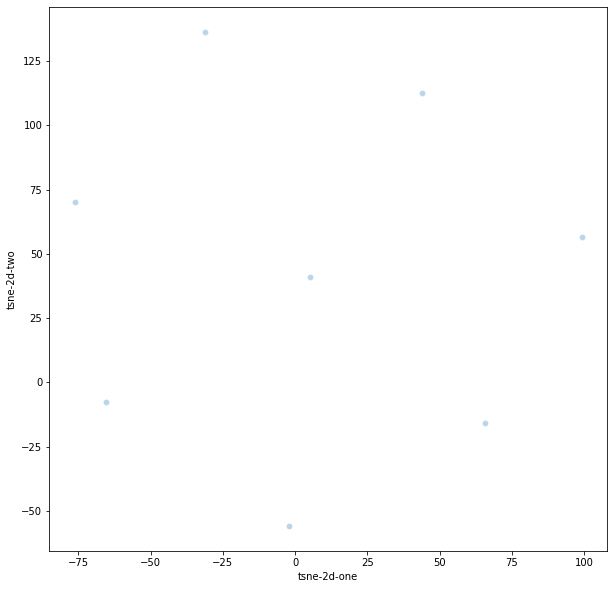

In [58]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(10,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
   # hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)

In [57]:
df_subset

,tsne-2d-one,tsne-2d-two
0,43.808395,112.675705
1,-76.258003,70.273918
2,65.665932,-15.857519
3,-65.369293,-7.608608
4,5.282924,41.108131
5,99.179970,56.732212
6,-2.089882,-55.960964
7,-31.140730,136.419708


In [33]:
for epoch in range(epochs):
        train(epoch)
        test(epoch)
        with torch.no_grad():
            sample = torch.randn(64, 20).to(device)
            sample = model.decode(sample).cpu()

NameError: name 'train' is not defined